In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pandas_profiling import ProfileReport
from pandas.plotting import autocorrelation_plot

import datetime
from sklearn.linear_model import LinearRegression

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Workspace, Dataset
from azureml.core.experiment import Experiment
from azureml.core import Model


In [2]:
WORKDIR = os.getcwd()
DATADIR = os.path.join(WORKDIR, '../data')

In [3]:
# Read in all csv files
df_weather = pd.read_csv(os.path.join(DATADIR, 'weather.csv'), parse_dates = ['data_index_'], index_col = 'data_index_')
df_load = pd.read_csv(os.path.join(DATADIR, 'load_actuals.csv'), parse_dates = ['data_index_'], index_col = 'data_index_')
df_wind = pd.read_csv(os.path.join(DATADIR, 'wind_solar_predictions.csv'), parse_dates = ['data_index_'], index_col = 'data_index_')

In [4]:
df_load.head()

,load_actuals_mw
data_index_,
2020-01-01 00:00:00+00:00,95.756328
2020-01-01 00:15:00+00:00,94.836196
2020-01-01 00:30:00+00:00,93.798127
2020-01-01 00:45:00+00:00,92.162902
2020-01-01 01:00:00+00:00,91.506670


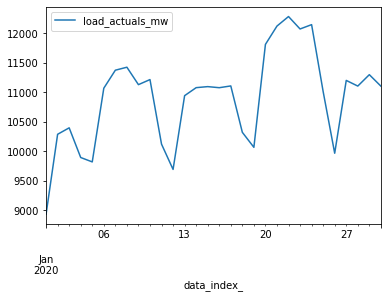

In [5]:
# Get daily load_actuals instead of every 15min in a day
df_load.resample('D').sum().head(30).plot()
df_load_daily = df_load.resample('D').sum()

In [6]:
# Creating new column day of week from 0 to 6 from Sunday to Saturday
df_load_daily['dayofweek'] = df_load_daily.index.weekday

In [7]:
df_load_daily.head()

,load_actuals_mw,dayofweek
data_index_,,
2020-01-01 00:00:00+00:00,8931.046100,2
2020-01-02 00:00:00+00:00,10287.299968,3
2020-01-03 00:00:00+00:00,10396.662102,4
2020-01-04 00:00:00+00:00,9893.106810,5
2020-01-05 00:00:00+00:00,9818.553867,6


In [8]:
#df_load.assign(weekday = df_load.index.weekday)

In [9]:
# Set rolling 
df_load_pred = (
    df_load_daily.groupby('dayofweek')
    .rolling(3, closed = 'left')
    .mean()
    .reset_index()
    .sort_values(by ='data_index_')
    .set_index('data_index_')
).rename(columns ={'load_actuals_mw' : 'load_pred_mw'})

In [10]:
df_load_pred.head(0)

,dayofweek,load_pred_mw
data_index_,,


In [11]:
# autocorrelation_plot(df_load_daily['load_actuals_mw'].dropna())
# pyplot.xlim(0,15)
# pyplot.title('Auto-correlation of daily demand over a 15 day period')
# pyplot.show()

<AxesSubplot:xlabel='data_index_'>

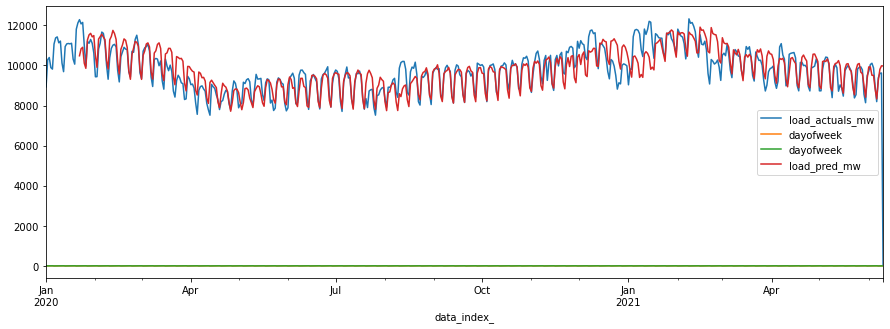

In [12]:
fig, ax = pyplot.subplots(figsize = [15, 5])
df_load_daily.plot( ax = ax)
df_load_pred.plot(ax = ax)

In [13]:
MAPE = abs((df_load_pred.load_pred_mw - df_load_daily.load_actuals_mw)/df_load_daily.load_actuals_mw).sum()/len(df_load_pred) * 100
MAPE

26.52331795756313

## Find out which rolling is the best with MAPE

In [ ]:
def generate_rolling(df, var, max_roll):
    for t in range(1, max_roll+1):
        df['load_pred_roll'+str(t)] = (
            df.groupby(var)
            .rolling(t, closed = 'left')
            .mean()
            .reset_index()
            .sort_values(by ='data_index_')
            .set_index('data_index_')
        )['load_actuals_mw']

In [ ]:
generate_rolling(df_load_daily, 'dayofweek', 15)

In [ ]:
df_load_daily.head(30)

In [ ]:
def mape(df, col1):
    MAPE =[]
    for i in df:
        MAPE.append(abs((col1 - df[i])/col1).sum()/len(col1) * 100)
    return list(enumerate(MAPE))

In [ ]:
mape(df_load_daily, df_load_daily.load_actuals_mw)

## Export Processed file and Predicted file

In [ ]:
# Processed file
df_load_daily.to_csv(os.path.join(DATADIR, 'df_load_daily_pred.csv'))

# Predicted file export
df_load_daily_pred.to_csv(os.path.join(DATADIR, 'df_load_daily_pred.csv'))

## Upload these files to Azure Datasets

In [14]:
# get the workspace from config.json
ws = Workspace.from_config()
# get the datastore to upload our data
datastore = ws.get_default_datastore()

In [28]:
datastore.upload(src_dir='../data', target_path='capstone_data')

Uploading an estimated of 8 files
Target already exists. Skipping upload for capstone_data\daily_train_test.csv
Target already exists. Skipping upload for capstone_data\daily_valid.csv
Target already exists. Skipping upload for capstone_data\input_data.csv
Target already exists. Skipping upload for capstone_data\load_actuals.csv
Target already exists. Skipping upload for capstone_data\readme.md
Target already exists. Skipping upload for capstone_data\weather.csv
Target already exists. Skipping upload for capstone_data\wind_solar_predictions.csv
Uploading ../data\df_load_daily.csv
Uploaded ../data\df_load_daily.csv, 1 files out of an estimated total of 6
Uploaded 1 files


$AZUREML_DATAREFERENCE_0c79fb08f04540888f28a26c86b75957

In [29]:
train_dataset = Dataset.Tabular.from_delimited_files(datastore.path('capstone_data/df_load_daily.csv'))

In [31]:
# Register the uploaded dataset

train_dataset.register(workspace = ws, name = 'daily_load_data1', description = 'daily load train test')

{
  "source": [
    "('workspaceblobstore', 'capstone_data/df_load_daily.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "2a229c4f-769f-4dc5-8994-3fe438bb0ef3",
    "name": "daily_load_data1",
    "version": 1,
    "description": "daily load train test",
    "workspace": "Workspace.create(name='mlops', subscription_id='ef7a4699-23c4-4d90-8b71-e5d1e63f9154', resource_group='mlops_bootcamp')"
  }
}

In [ ]:
# Check the file
train_dataset.take(3).to_pandas_dataframe()

## Now, Go to create_batch.ipynb file 